In [34]:
# Google drive Path settings

supplier_id = 'SkellefteaKraft'
detect_img_save_dir = "/home/jovyan/work/SkellefteaKraft/detectimg/"
MODEL_PATH = "/home/jovyan/work/models.yaml"
pdf_dir ='/home/jovyan/work/SkellefteaKraft/pdf'
pdf2img_dir ='/home/jovyan/work/SkellefteaKraft/pdf2img'
annotation_xml_path = '/home/jovyan/work/SkellefteaKraft/annotations/fakt0001-03.xml'

dpi = 300


In [35]:
## Import required package
import pytesseract
from pytesseract import Output
import pdf2image
import cv2
import os
import matplotlib.pyplot as plt
import glob


In [36]:

import xml.etree.ElementTree as ET

classes =  ['m','h','fm1','fm2','fm3','fd','t','ms']

def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(output_path, in_file):
    basename = os.path.basename(in_file)
    basename_no_ext = os.path.splitext(basename)[0]

    with open(output_path + basename_no_ext + '.txt', "w") as out_file :
        tree = ET.parse(in_file)
        root = tree.getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in classes or int(difficult)==1:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
            bb = convert((w,h), b)
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')


from shutil import copy

def copy_im(output_path,im_dir, in_file):
    basename = os.path.basename(in_file)
    basename_no_ext = os.path.splitext(basename)[0]

    copy(im_dir + basename_no_ext +'.jpg' , output_path)


In [37]:

## Convert PDFs to jpg 

images = pdf2image.convert_from_path(pdf_dir+"/Fakturaforklaring_eng_150306.pdf", dpi=dpi, output_file="Fakturaforklaring_eng_150306", output_folder=pdf2img_dir, fmt='jpg', paths_only=True)

# count =0
# for pdf_path in glob.glob(pdf_dir + '/*.pdf'):
#     image_filename = pdf_path.split('/')[-1][:-4]
#     print(pdf_path, image_filename)
#     images = pdf2image.convert_from_path(pdf_path, dpi=dpi, output_file=image_filename, output_folder=output_dir, fmt='jpg', paths_only=True)
#     #print(type(images))
#     #print(len(images))
#     count=count+1
#     if(count>=50): 
#       break



In [38]:
# Read Annotations

import xml.etree.ElementTree as ET


def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text
        clss = None
        ymin, xmin, ymax, xmax = None, None, None, None


        clss = str(boxes.find("name").text)
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append( {'class' : clss  ,'box' : list_with_single_boxes }  )

    return filename, list_with_all_boxes

def crop_im(im,coord,show=True):
    xmin,ymin,xmax,ymax = coord
    crop = im[ymin:ymax,xmin:xmax]
    if show:
        plt.imshow(crop)
    return crop

def ocr(im):
    return pytesseract.image_to_string(im,lang='Latin')




In [ ]:
## Cropping images based on annotation xml

image_path = os.path.join(pdf2img_dir,'Fakturaforklaring_eng_1503060001-1.jpg')
image = cv2.imread(image_path)
plt.imshow(image)
im_name, boxes = read_content(annotation_xml_path)

im_name, boxes = read_content(annotation_xml_path)

box_index = 1
_= crop_im(image, boxes[box_index]['box'])

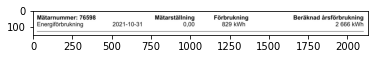

In [40]:
## Cropping images based on annotation xml

image_path = os.path.join(pdf2img_dir,'fakt0001-03.jpg')
image = cv2.imread(image_path)
plt.imshow(image)
im_name, boxes = read_content(annotation_xml_path)

im_name, boxes = read_content(annotation_xml_path)

box_index = 1
_= crop_im(image, boxes[box_index]['box'])


In [ ]:
### Crop Images using Annotations and OCR for text extraction
## Uncomment below install commands first time.
#!sudo apt-get install tesseract-ocr
#!sudo apt-get install tesseract-ocr-script-latn

def crop_im(im,coord,show=True):
    xmin,ymin,xmax,ymax = coord
    crop = im[ymin:ymax,xmin:xmax]
    if show:
        plt.imshow(crop)
    return crop

def ocr(im):
    return pytesseract.image_to_string(im,lang='Latin')

def get_text(boxes,image,skip_class=[]):
    for box_index,box in enumerate(boxes) : 
        print('processing : ',box_index)
        crop_cls = boxes[box_index]['class']
        if crop_cls not in skip_class :
            crop = crop_im(image, boxes[box_index]['box'],show=False)
            boxes[box_index]['text'] = ocr(crop)
    return boxes

# Uncheck first time.
#!pip install pillow==4.1.1
#%reload_ext autoreload
#%autoreload

image_path = os.path.join(pdf2img_dir,'Fakturaforklaring_eng_1503060001-1.jpg')
image = cv2.imread(image_path)
box_index = 4
crop_cls = boxes[box_index]['class']
crop = crop_im(image, boxes[box_index]['box'])

text = ocr(crop)
print(crop_cls, '\n',text)

In [ ]:
### Evaluate Layout Detection model with sample invoices
import layoutparser as lp
import yaml
import datetime
import uuid
import os

SUPPORTED_SUPPLIERS = ["SkellefteaKraft"]
MULTI_OCR = True
OCR_MODE = "ACCURATE"  # ['FAST',"ACCURATE"]

EXRACTION_RESOLUTION = 300
BASE_DIR = "/home/jovyan/work"
LOGS_DIR = os.path.join(BASE_DIR, "logs")
LOGS = "{}/{}_{}.logs".format(LOGS_DIR, str(datetime.datetime.now())[:10], uuid.uuid4())
os.system("mkdir - p {}".format(LOGS_DIR))


# DEV TOOLS
troubleShoot = False
DEBUG = False
SAVE = True
INTM_OUTPUT_PATH = ""


CLASS_MAPPING = {0: "m", 1: "fm1", 2: "fm2", 3: "fm3", 4: "fd", 5: "t", 6: "ms", 7: "h"}
global layout_models
layout_models = {}

def load_model(supplier_id, class_mapping):
    print("loading model for : ", supplier_id)

    with open(MODEL_PATH, "r") as stream:
        model_meta = yaml.safe_load(stream)

    layout_models[supplier_id] = lp.Detectron2LayoutModel(
        model_meta[supplier_id]["CONFIG"],
        model_path=model_meta[supplier_id]["MODEL_PATH"],
        label_map=class_mapping,
        extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
    )
def transform_to_dict(layouts):

    raw_layouts = []
    for idx, ele in enumerate(layouts):
        raw_layouts.append(
            {
                "class": ele.type,
                "coords": list(ele.coordinates),
                "score": format(ele.score, ".2f"),
            }
        )

    return raw_layouts

def detect_layout(image,image_name, supplier_id, class_mapping):

    if supplier_id not in layout_models.keys():
        load_model(supplier_id, class_mapping)

    layouts = layout_models[supplier_id].detect(image)
    bbox, tag = draw_box(layouts, image, image_name, 1, detect_img_save_dir)
    return transform_to_dict(layouts)

def update_box_format(coords, tags, score):
    final_coord = []
    for idx, coord in enumerate(coords):
        temp_dict = {}
        vert = []
        temp_dict["identifier"] = str(uuid.uuid4())
        vert.append({"x": coord[0], "y": coord[1]})
        vert.append({"x": coord[2], "y": coord[1]})
        vert.append({"x": coord[2], "y": coord[3]})
        vert.append({"x": coord[0], "y": coord[3]})
        temp_dict["boundingBox"] = {}
        temp_dict["boundingBox"]["vertices"] = vert
        final_coord.append(temp_dict)
    return final_coord

def draw_box(layout, image, name, iteration, save_dir):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 2
    thickness = 3
    region_color = (200, 50, 10)
    bbox = []
    tag = []
    scores = []
    for idx, ele in enumerate(layout):
        bbox.append(list(ele.coordinates))
        tag.append(ele.type)
        scores.append(format(ele.score, ".2f"))
    layouts = update_box_format(bbox, tag, scores)
    regions = layouts  # remove_overlap.remove_overlap(layouts)
    image = cv2.putText(
        image,
        str(iteration),
        (
            50,
            50,
        ),
        font,
        fontScale,
        region_color,
        thickness,
        cv2.LINE_AA,
    )

    for index, region in enumerate(regions):
        image = cv2.rectangle(
            image,
            (
                int(region["boundingBox"]["vertices"][0]["x"]),
                int(region["boundingBox"]["vertices"][0]["y"]),
            ),
            (
                int(region["boundingBox"]["vertices"][2]["x"]),
                int(region["boundingBox"]["vertices"][2]["y"]),
            ),
            (10, 20, 250),
            5,
        )
        image = cv2.putText(
            image,
            "{} {}".format(tag[index], scores[index]),
            (
                int(region["boundingBox"]["vertices"][0]["x"]) - 50,
                int(region["boundingBox"]["vertices"][0]["y"]) - 20,
            ),
            font,
            fontScale,
            region_color,
            thickness,
            cv2.LINE_AA,
        )
    cv2.imwrite(os.path.join(save_dir, str(name)), image)
    print(save_dir+"<>"+str(name))
    plt.imshow(image)
    return bbox, tag

img_dir ='/home/jovyan/work/SkellefteaKraft/pdf2img'
image_name = 'Fakturaforklaring_eng_1503060001-2.jpg'
image_path = os.path.join(img_dir,image_name)
print(image_path)
image = cv2.imread(image_path)
detect_layout(image,image_name, supplier_id, CLASS_MAPPING)
